In [1]:
import numpy as np

# Load txt file

In [2]:
with open('../data/anna.txt', 'r') as f:
    text = f.read()
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

# Tokenization

In [3]:
chars = tuple(set(text))
int_to_chars = dict(enumerate(chars))
char_to_int = {char:i for i, char in int_to_chars.items()}

In [4]:
first_100 = np.array([char_to_int[char] for char in text[:100]])

# One-Hot Encoding

In [5]:
def one_hot_encoder(arr, n_labels):
    
    # initialise one-hot output with zeros
    one_hot = np.zeros([arr.size, n_labels], dtype=np.float32)
    
    # fill with 1s
    one_hot[np.arange(arr.size), arr.flatten()] = 1
    
    # reshape back to arr
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [6]:
# test
one_hot = one_hot_encoder(first_100, len(chars))

print(one_hot.shape)
print(one_hot)

(100, 83)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Splitting into mini-batches

In [7]:
def create_batches(arr, batch_size, seq_len):
    
    # number of batches
    num_batch = (len(arr)-1) // (batch_size*seq_len)
    arr = arr[:num_batch*batch_size*seq_len + 1] # remove remaining chars
    
    # remove last text and first text for x & y respectively
    x = arr[:-1]
    y = arr[1:]
    
    # reshape them into number of batches x batch size x seq length x number of features
    x = x.reshape(num_batch, batch_size, seq_len, -1)
    y = y.reshape(num_batch, batch_size, seq_len, -1)
    
    return x, y

In [8]:
# test
batch_first_100_x, batch_first_100_y = create_batches(one_hot, 3, 4)
print(batch_first_100_x.shape)
print(batch_first_100_y.shape)

(8, 3, 4, 83)
(8, 3, 4, 83)


In [9]:
batch_first_100_y

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..

# RNN model

In [10]:
import torch
from torch import nn
import torch.nn.functional as F

In [11]:
# check for gpu
cuda = torch.cuda.is_available()

In [12]:
class charRNN(nn.Module):
    
    def __init__(self, chars, n_hidden, n_layers, drop_prob, bi_dir, rnn_cell_type='lstm'):
        super().__init__()
        
        # create char dictionaries
        self.chars = chars # uniques characters
        self.int_to_char = dict(enumerate(self.chars))
        self.char_to_int = {char:i for i, char in int_to_chars.items()}
        
        # RNN Layer
        if rnn_cell_type == 'lstm':
            self.rnn = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                               dropout=drop_prob, batch_first=True, bidirectional=bi_dir)
        elif rnn_cell_type == 'gru':
            self.rnn = nn.GRU(len(self.chars), n_hidden, n_layers, 
                              dropout=drop_prob, batch_first=True, bidirectional=bi_dir)
        else:
            self.rnn = nn.RNN(len(self.chars), n_hidden, n_layers, 
                              dropout=drop_prob, batch_first=True , bidirectional=bi_dir)
            
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # dense layer
        self.dense = nn.Linear(n_hidden, len(self.chars))
        
        # assign hyperparameters
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        
    def forward(self, x, hidden):
        
        # run text and hidden through the network
        r_output, hidden = self.rnn(x, hidden)
        
        # pass through dropout layer
        out = self.dropout(r_output)
        
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        # dense layer
        out = self.dense(out)
        
        return out, hidden
    
    
    def init_hidden(self, batch_size, cuda):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if cuda:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [13]:
# hyperparamters
n_hidden = 32
n_layers = 2
drop_prob = 0.2
bi_dir = False
rnn_cell_type = 'lstm'

# create network
char_rnn = charRNN(chars, n_hidden, n_layers, drop_prob, bi_dir, rnn_cell_type=rnn_cell_type)
print(char_rnn)

if cuda:
    char_rnn.cuda()

charRNN(
  (rnn): LSTM(83, 32, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=32, out_features=83, bias=True)
)


In [14]:
# Loss & optimizer
lr = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_rnn.parameters(), lr=lr)

In [15]:
epochs = 50
batch_size = 64
seq_len = 100
valid_size = 0.1

clip = 5 # clip gradients

# train and validation loss
train_loss = []
val_loss = []
n_print = 10

# create training and validation data
text_encoded = np.array([char_to_int[char] for char in text])
val_idx = int(len(text_encoded)*(1-valid_size))
one_hot = one_hot_encoder(text_encoded, len(chars))
train_text, val_text = one_hot[:val_idx], one_hot[val_idx:]

for e in range(epochs):
    
    # initialise hidden state
    hid = char_rnn.init_hidden(batch_size, cuda)
    
    running_train_loss = []
    
    # create batches
    x, y = create_batches(train_text, batch_size, seq_len)
    # loop through each batch
    for batch in range(x.shape[0]):
        inputs, targets = x[batch], y[batch]
        # convert to tensors
        inputs, targets = torch.from_numpy(inputs), torch.from_numpy(targets)
        
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            
        # zero out gradients
        char_rnn.zero_grad()
        
        # run forward prop
        output, hid = char_rnn(inputs, hid)
        hid = tuple([each.data for each in hid])
        
        # calculate loss
        loss = criterion(output, torch.max(targets.view(batch_size*seq_len, -1), 1)[1])
        running_train_loss.append(loss.item())
        loss.backward()
        
        # clip gradient to prevent exploding gradients
        nn.utils.clip_grad_norm_(char_rnn.parameters(), clip)
        optimizer.step()
    
    train_loss.append(np.mean(running_train_loss))
    
    val_hid = char_rnn.init_hidden(batch_size, cuda)
    running_val_loss = []
    char_rnn.eval() # set to eval to prevent accidental updates of weights on validation set

    x, y = create_batches(val_text, batch_size, seq_len)
    # loop through each batch
    for batch in range(x.shape[0]):
        inputs, targets = x[batch], y[batch]
        # convert to tensors
        inputs, targets = torch.from_numpy(inputs), torch.from_numpy(targets)

        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # run forward prop
        output, val_hid = char_rnn(inputs, val_hid)
        val_hid = tuple([each.data for each in val_hid])

        # calculate loss
        loss = criterion(output, torch.max(targets.view(batch_size*seq_len, -1), 1)[1])
        running_val_loss.append(loss.item())
    
    val_loss.append(np.mean(running_val_loss))
    char_rnn.train()
        
    if e % n_print == 0:
        print(f"Epochs: {int(e+1)}/{int(epochs)} --- Train loss: {np.mean(running_train_loss)} --- Validation loss: {np.mean(running_val_loss)}")
        
print(f"Epochs: {int(e+1)}/{int(epochs)} --- Train loss: {np.mean(running_train_loss)} --- Validation loss: {np.mean(running_val_loss)}")

Epochs: 1/50 --- Train loss: 2.8183773273208237 --- Validation loss: 2.3861084522739535
Epochs: 11/50 --- Train loss: 1.9340277850414263 --- Validation loss: 1.8776989367700392
Epochs: 21/50 --- Train loss: 1.8605353614335418 --- Validation loss: 1.8230656769967848
Epochs: 31/50 --- Train loss: 1.8365029771695427 --- Validation loss: 1.8081970061025312
Epochs: 41/50 --- Train loss: 1.822859485944112 --- Validation loss: 1.8035618412879206
Epochs: 50/50 --- Train loss: 1.8125959976599635 --- Validation loss: 1.7974479929093392


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

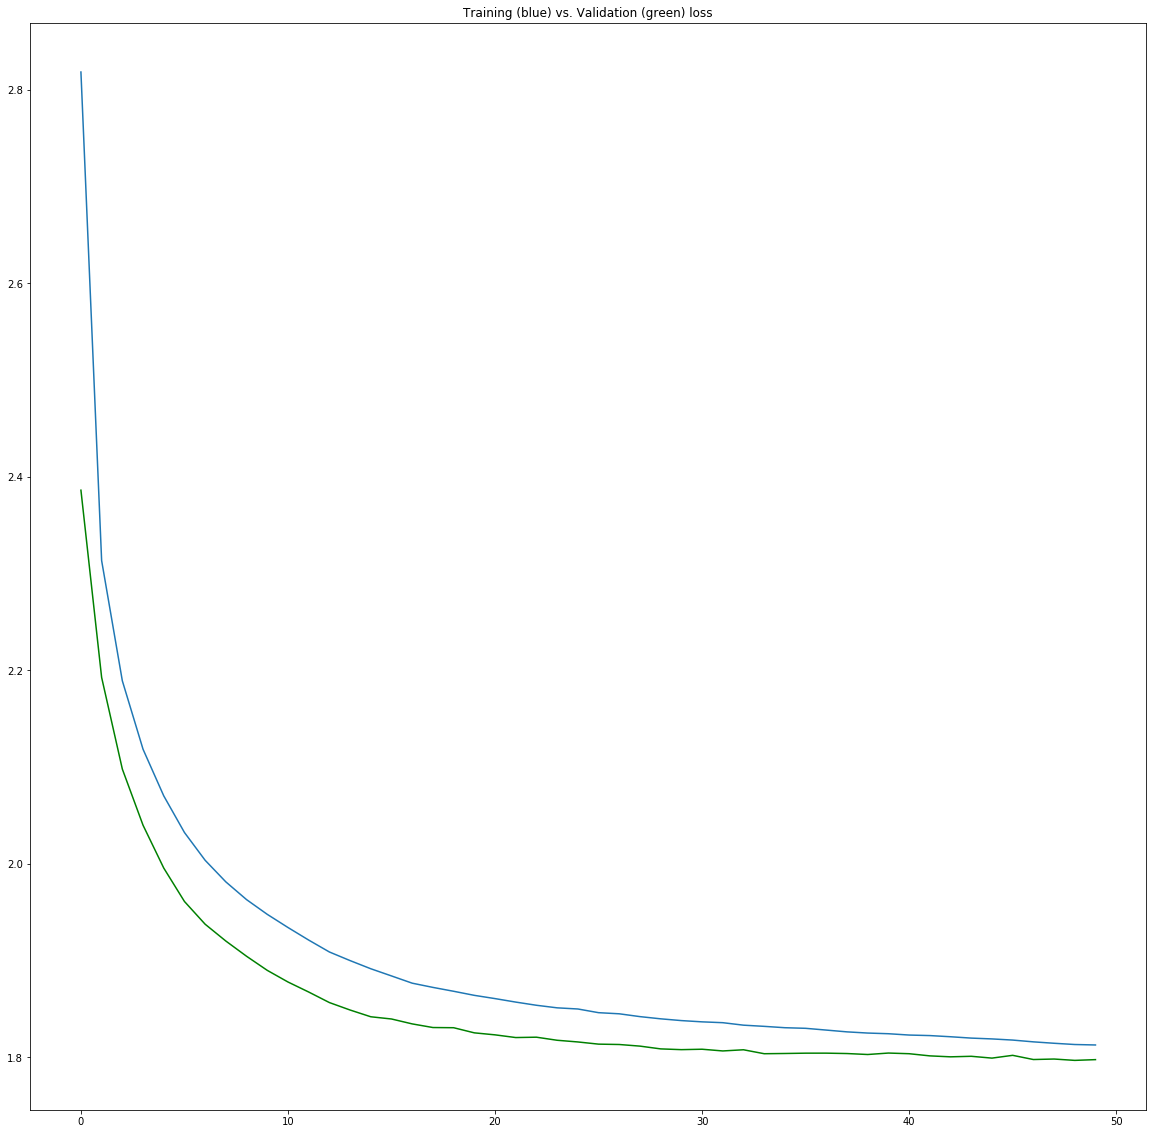

In [21]:
# Plot training loss vs validation loss
plt.figure(figsize=(20,20))
sns.lineplot(y=train_loss, x=range(epochs))
plt.plot(range(epochs), val_loss, color='green')
plt.title('Training (blue) vs. Validation (green) loss')
plt.show()

# Prediction

In [27]:
initial = 'Banana'
top_k = 5 # number of top probabilities to randomly draw from

char_rnn.eval()

output = [char for char in initial]

hid = char_rnn.init_hidden(1, cuda)

# loop through the characters in initial to update hid
for char in initial:
    
    # transform character to int and one-hot encode
    x = np.array([[char_rnn.char_to_int[char]]])
    x = one_hot_encoder(x, len(char_rnn.chars))
    inputs = torch.from_numpy(x) # convert to tensor
    
    # move tensor to gpu if exist
    if cuda:
        inputs = inputs.cuda()
    
    # detach hidden state from history
    hid = tuple([each.data for each in hid])
    
    # run through forward prop
    out, hid = char_rnn(inputs, hid)
    
    # convert to probabilities
    p = F.softmax(out, dim=1).data
    
    # move back to cpu
    if cuda:
        p = p.cpu()
    
    # get top characters
    p, top_char = p.topk(top_k)
    top_char = top_char.numpy().squeeze()
    p = p.numpy().squeeze()
    
    # randomly draw from top characters
    char_out = np.random.choice(top_char, p=p/p.sum())
    
    # convert back to character
    char_out = char_rnn.int_to_char[char_out]

# append the last character
output.append(char_out)

In [29]:
generate = 1000 # number of characters to generate after

# predict next characters
for i in range(generate):
    
    # transform character to int and one-hot encode
    x = np.array([[char_rnn.char_to_int[output[-1]]]])
    x = one_hot_encoder(x, len(char_rnn.chars))
    inputs = torch.from_numpy(x) # convert to tensor
    
    # move tensor to gpu if exist
    if cuda:
        inputs = inputs.cuda()
    
    # detach hidden state from history
    hid = tuple([each.data for each in hid])
    
    # run through forward prop
    out, hid = char_rnn(inputs, hid)
    
    # convert to probabilities
    p = F.softmax(out, dim=1).data
    
    # move back to cpu
    if cuda:
        p = p.cpu()
    
    # get top characters
    p, top_char = p.topk(top_k)
    top_char = top_char.numpy().squeeze()
    p = p.numpy().squeeze()
    
    # randomly draw from top characters
    char_out = np.random.choice(top_char, p=p/p.sum())
    
    # convert back to character
    char_out = char_rnn.int_to_char[char_out]

    # append the last character
    output.append(char_out)

In [32]:
print(''.join(output))

Bananad in that, and sought he cishe
was with his have with is her humation was she had helking the so as interensed he wanted of the him his all an thing thought why which
the more and a mes had for the thought at the hand her had saw worth to sensing of the hards as the to her when the hilked out as
how. She sore he called to the touling that then he said
that they seted he
he the moving it
an to the same were say, when at the handing was said if his how as what, what all that as it's harfer at his tabling to said ous any at
her with his at her his so son, and too she wurse, art the hunfing well of
the moving his wanched all sees,, she had feinetiatious an heel he set taken the something asked in the saclith the so with the husbard is, he wuttid he her had what how thoughe was sore, and as the pect here, and hursing a hand to saw in thong was here how to anywiun on him, have
the the
part to telled
all him, that an,
he she was wells her a carrian his to tellering to the peasarding and

# Conclusion
As you can see, the text doesnt really make too much sense, but at least most of the characters are pieced together to form complete words. This is after training for approximately 5 to 10 mins to run through the 50 epochs.

As seen from the train and validation loss curve, I believe that I can run more epochs to further improve the loss. On top of that, I believe the architecture of the RNN is relatively simple and using a different set of hyperparameters can allow it to map much more complex functions which could reduce the loss even further.

# References
udacity deep learning w/ pytorch course
- https://github.com/udacity/deep-learning-v2-pytorch/tree/master/recurrent-neural-networks/char-rnn

PyTorch
- https://pytorch.org/